In [1]:
#https://github.com/BraveY/AI-with-code/blob/master/MNIST-detection/MNIST-detection.ipynb
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms,utils

In [2]:
# 数据预处理——转tensor，归一化
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

In [3]:
# 加载数据
train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)
# 60000 : 10000
test_data = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [4]:
# 数据准备 batch_size=64
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,
                                          shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,
                                          shuffle=True,num_workers=2)

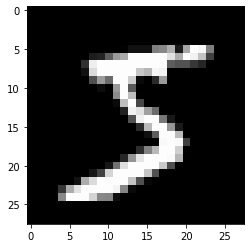

In [5]:
# 生成一个图像
oneimg,label = train_data[0]
grid = utils.make_grid(oneimg)
grid = grid.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
grid = grid * std + mean
plt.imshow(grid)
plt.show()

tensor(5) tensor(0) tensor(0) tensor(7) tensor(1) tensor(2) tensor(0) tensor(5) 
tensor(6) tensor(0) tensor(4) tensor(2) tensor(9) tensor(8) tensor(7) tensor(1) 
tensor(1) tensor(3) tensor(1) tensor(6) tensor(4) tensor(7) tensor(1) tensor(9) 
tensor(1) tensor(7) tensor(7) tensor(4) tensor(2) tensor(1) tensor(5) tensor(5) 
tensor(3) tensor(2) tensor(3) tensor(1) tensor(7) tensor(4) tensor(2) tensor(3) 
tensor(2) tensor(2) tensor(1) tensor(9) tensor(5) tensor(1) tensor(1) tensor(7) 
tensor(1) tensor(4) tensor(7) tensor(9) tensor(3) tensor(9) tensor(6) tensor(8) 
tensor(7) tensor(9) tensor(5) tensor(4) tensor(9) tensor(1) tensor(8) tensor(4) 


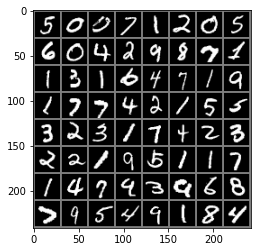

In [6]:
# 生成一个batch的图像，一个batch64个图像
images, lables = next(iter(train_loader))
img = utils.make_grid(images)
# transpose 转置函数(x=0,y=1,z=2),x->z,y->x,z->y
img = img.numpy().transpose(1,2,0)
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 == 0:
        print(end='\n')
plt.imshow(img)
plt.show()

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
            # 1*28*28
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )      # 32*28*28

        self.layer2 = nn.Sequential(
            nn.MaxPool2d(2,2)
        )   # 32*14*14

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )   # 64*14*14

        self.layer4 = nn.Sequential(
            nn.MaxPool2d(2,2)
        )   # 64*7*7

        self.fc = nn.Sequential(
            nn.Linear(64*7*7,1024), # 64*7*7->1024
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),    # 1024->512
            nn.ReLU(inplace=True),
            nn.Linear(512,10)       # 512->10，最后只有10类
        )

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 64 * 7* 7)#将数据平整为一维的
        x = self.fc(x)
        return x

net = CNN()

In [11]:
class CNN2(nn.Module): # 卷积-池化-卷积-池化-全连接 这个废弃了
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(    # 卷积
            nn.Conv2d(1, 25, kernel_size=3),
            nn.BatchNorm2d(25),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(    # 池化
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(    # 卷积
            nn.Conv2d(25, 50, kernel_size=3),
            nn.BatchNorm2d(50),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(    # 池化
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(    # 全连接
            nn.Linear(50 * 5 * 5, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
net = CNN2()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9) #SGDM
#也可以选择Adam优化方法
#optimizer = torch.optim.Adam(net.parameters(),lr=0.01)

In [9]:
import datetime
starttime = datetime.datetime.now() #记录时间

train_accs = []
train_loss = []
test_accs = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

for epoch in range(2): # 训练5次
    running_loss = 0.0
    for i,data in enumerate(train_loader,0):#0为下标起始位置
        inputs,labels = data[0].to(device), data[1].to(device) # 数据送到GPU
        optimizer.zero_grad() # 初始为0，清除上个batch的梯度信息

        #前向+后向+优化
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # loss 的输出，每个一百个batch输出，平均的loss
        # running_loss += loss.item()
        # if i%100 == 99:
        #     print('[%d,%5d] loss :%.3f' %
        #          (epoch+1,i+1,running_loss/100))
        #     running_loss = 0.0
        train_loss.append(loss.item())

        # 训练曲线的绘制 一个batch中的准确率
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)# labels 的长度
        correct = (predicted == labels).sum().item() # 预测正确的数目
        train_accs.append(100*correct/total)

endtime = datetime.datetime.now()
time = (endtime - starttime).seconds
print("训练结束，用时",time)

D:\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


训练结束，用时 16


In [10]:
# 保存模型
PATH = './mnist_net_best.pth'
torch.save(net.state_dict(), PATH)

In [11]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# 画图
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=20)
    plt.xlabel("迭代次数", fontsize=14)
    plt.ylabel("准确率(%)", fontsize=14)
    plt.plot(iters, costs,color='red',label=label_cost)
    plt.plot(iters, accs,color='green',label=lable_acc)
    plt.legend()
    plt.grid()
    plt.show()

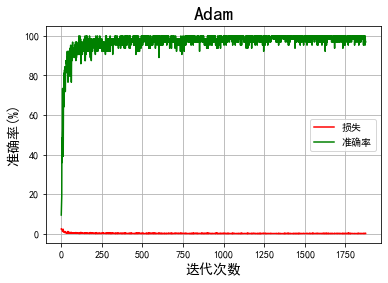

In [12]:
train_iters = range(len(train_accs))
draw_train_process('Adam',train_iters,train_loss,train_accs,'损失','准确率')

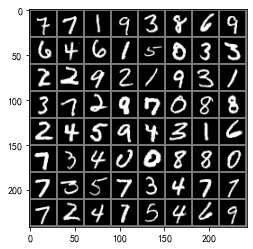

真实值:  7 7 1 9 3 8 6 9 6 4 6 1 5 0 3 3 2 2 9 2 1 9 3 1 3 7 2 8 7 0 8 8 2 4 5 9 4 3 1 6 7 3 4 0 0 8 8 0 7 3 5 7 3 4 7 7 7 2 4 7 5 4 6 9


In [13]:
# 选一个batch测试
dataiter = iter(test_loader)
images, labels = dataiter.next()

# 输出一个batch的图像
test_img = utils.make_grid(images)
test_img = test_img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()
print('真实值: ', ' '.join('%d' % labels[j] for j in range(64)))

In [14]:
test_net = CNN()   # 换模型的时候记得改
test_net.load_state_dict(torch.load(PATH)) # 加载刚存的本地模型
test_out = test_net(images)

In [15]:
# 抽一个batch看一下
_, predicted = torch.max(test_out, dim=1)

print('真实值: ', ' '.join('%d' % labels[j] for j in range(64)))
print('预测值: ', ' '.join('%d' % predicted[j]
                              for j in range(64)))

真实值:  7 7 1 9 3 8 6 9 6 4 6 1 5 0 3 3 2 2 9 2 1 9 3 1 3 7 2 8 7 0 8 8 2 4 5 9 4 3 1 6 7 3 4 0 0 8 8 0 7 3 5 7 3 4 7 7 7 2 4 7 5 4 6 9
预测值:  7 7 1 9 3 8 6 9 6 4 6 1 5 0 3 3 2 2 9 2 1 9 3 1 3 7 2 8 7 0 8 8 2 4 5 9 4 3 1 6 7 3 4 0 0 8 8 0 7 3 5 7 3 4 7 7 7 2 4 7 5 4 6 9


In [16]:
# 测试集准确率
correct = 0
total = 0
with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)# labels 的长度
        correct += (predicted == labels).sum().item() # 预测正确的数目
print('Accuracy of the network on the  test images: %f %%' % (100. * correct / total))

Accuracy of the network on the  test images: 98.930000 %


In [17]:
# 每一类准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        # print("predicted",predicted.numpy())
        # print("labels",labels.numpy())
        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %4f %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98.979592 %
Accuracy of 1 : 99.647577 %
Accuracy of 2 : 99.031008 %
Accuracy of 3 : 98.910891 %
Accuracy of 4 : 99.287169 %
Accuracy of 5 : 99.663677 %
Accuracy of 6 : 99.373695 %
Accuracy of 7 : 99.027237 %
Accuracy of 8 : 97.022587 %
Accuracy of 9 : 98.216056 %


In [18]:
# 性能评估过程
y_test = np.array([]) # 测试集
y_pred = np.array([]) # 预测结果
#print(y_test)

with torch.no_grad():# 进行评测的时候网络不更新梯度
    for data in test_loader:
        images, labels = data
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test = np.append(y_test,labels.numpy()) # 补充测试集
        y_pred = np.append(y_pred,predicted.numpy())

# print(y_test.shape)
# print(y_pred[:128])

In [19]:
from sklearn.metrics import precision_score,recall_score,f1_score
# 评估
print("精确率",precision_score(y_test, y_pred, average='weighted'))
print("召回率",recall_score(y_test, y_pred, average='weighted'))
print("F1度量值",f1_score(y_test, y_pred, average='weighted'))


精确率 0.9890527310079026
召回率 0.989
F1度量值 0.9889951334820546
